In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, date


from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

from datetime import datetime, date
import csv

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = 4.8,3.2
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.fancybox'] = True

/Users/Jay/miniconda3/envs/sf-walk-safety/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read data

In [2]:
#dataset = 'thefts'
dataset = 'robberies'

if dataset == 'thefts':
    fulldf = pd.read_pickle('../data/theft-street.p')
    lowercase = 'thefts'
    uppercase = 'Thefts'
elif dataset == 'robberies':
    fulldf = pd.read_pickle('../data/robbery-street.p')
    lowercase = 'robberies'
    uppercase = 'Robberies'

In [3]:
# Add month and year columns
fulldf['month'] = fulldf.date.apply(lambda x: x.month)
fulldf['year'] = fulldf.date.apply(lambda x: x.year)

# Read weather data
weatherfull = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")


# Convert celsius to fahrenheit
def celsius2fahrenheit(T):
    return T * 1.8 + 32
weatherfull['TMAX'] = weatherfull['TMAX'].apply(celsius2fahrenheit)
weatherfull['TMIN'] = weatherfull['TMIN'].apply(celsius2fahrenheit)

# Join with weather
print 'merge with weather'
print 'before merge', fulldf.shape
fulldf = fulldf.merge(weatherfull,how="inner",left_on="date",right_on="DATE")
print 'after merge', fulldf.shape
print ''

# Filter out 2016 incidents
df = fulldf[fulldf.year < 2016]
print 'fulldf', fulldf.shape
print 'df 2003-2015', df.shape
print ''
weather = weatherfull[weatherfull.DATE < date(2016, 1, 1)]
print 'full weather', weatherfull.shape
print 'weather 2003-2015', weather.shape
print ''


# Aggregate into daily counts
groupbydate = df.groupby(by=['date','dayofweek','month','year','PRCP','TMAX','TMIN']).size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
print 'days from 2003/01/01 to 2015/12/31 :', date(2016,1,1)-date(2003,1,1)
print 'daily aggregate', groupbydate.shape

# Add zero counts for missing days
#groupbydate.set_index('date',inplace=True)
#groupbydate = groupbydate.reindex(pd.Index(weather[weather.DATE < date(2016, 1, 1)]['DATE'],name='date'))
#groupbydate.reset_index(inplace=True)
#print 'new daily aggregate', groupbydate.shape
#groupbydate.head()

# Add zero counts for missing days
groupbydate = groupbydate[['date','dayofweek','month','year','count']].merge(weather,how="outer",left_on="date",right_on="DATE")
groupbydate['date']=groupbydate['DATE']
groupbydate.drop('DATE',axis=1,inplace=True)
print 'new daily aggregate', groupbydate.shape
groupbydate[groupbydate.isnull().any(axis=1)]

merge with weather
before merge (25087, 13)
after merge (25087, 17)

fulldf (25087, 17)
df 2003-2015 (24889, 17)

full weather (4836, 4)
weather 2003-2015 (4748, 4)

days from 2003/01/01 to 2015/12/31 : 4748 days, 0:00:00
daily aggregate (4688, 8)
new daily aggregate (4748, 8)


,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4688,2003-06-14,NaN,NaN,NaN,NaN,0.0,62.96,51.98
4689,2003-11-26,NaN,NaN,NaN,NaN,0.0,62.06,48.92
4690,2004-02-08,NaN,NaN,NaN,NaN,0.0,60.08,42.98
4691,2004-05-26,NaN,NaN,NaN,NaN,0.0,64.94,55.94
4692,2004-10-01,NaN,NaN,NaN,NaN,0.0,62.96,53.06
4693,2005-01-25,NaN,NaN,NaN,NaN,0.3,55.94,46.04
4694,2005-03-31,NaN,NaN,NaN,NaN,0.0,71.96,41.00
4695,2005-07-07,NaN,NaN,NaN,NaN,0.0,62.96,53.06
4696,2006-09-05,NaN,NaN,NaN,NaN,0.0,64.04,51.98
4697,2006-10-10,NaN,NaN,NaN,NaN,0.0,66.92,53.96


In [4]:
groupbydatena = groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:]
groupbydatena['count'] = 0
groupbydatena['month'] = groupbydatena['date'].apply(lambda x: x.month)
groupbydatena['year'] = groupbydatena['date'].apply(lambda x: x.year)
groupbydatena['dayofweek'] = groupbydatena['date'].apply(lambda x: x.strftime("%A"))

groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:] = groupbydatena

groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-11-16,Monday,11.0,2015.0,0.0,0.0,60.98,46.94
4744,2015-11-25,Wednesday,11.0,2015.0,0.0,1.0,53.06,42.98
4745,2015-11-27,Friday,11.0,2015.0,0.0,0.0,55.94,46.94
4746,2015-12-02,Wednesday,12.0,2015.0,0.0,0.0,60.08,50.00
4747,2015-12-06,Sunday,12.0,2015.0,0.0,1.3,60.08,51.08


In [5]:
groupbydate.sort_values('date',inplace=True)
groupbydate.reset_index(drop=True,inplace=True)
groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-12-27,Sunday,12.0,2015.0,4.0,0.0,46.94,39.02
4744,2015-12-28,Monday,12.0,2015.0,5.0,1.5,48.92,39.92
4745,2015-12-29,Tuesday,12.0,2015.0,2.0,0.0,55.04,41.00
4746,2015-12-30,Wednesday,12.0,2015.0,3.0,0.8,48.02,41.00
4747,2015-12-31,Thursday,12.0,2015.0,5.0,0.0,51.08,42.08


# Over time

## Yearly counts

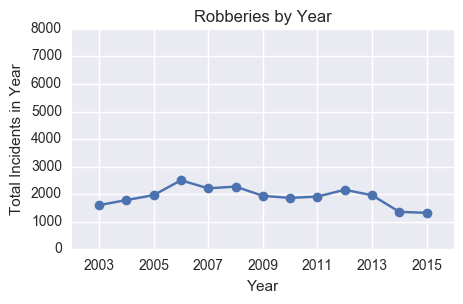

In [6]:
yearlytotal = df.year.value_counts().to_frame(name="count").sort_index()
yearlytotal['year'] = yearlytotal.index
plt.plot(yearlytotal['year'],yearlytotal['count'],'o-')
plt.xlabel('Year')
plt.ylabel('Total Incidents in Year')
plt.title(uppercase+' by Year')
plt.axis([2002, 2016, 0, 8000])
plt.xticks(range(2003,2016,2), range(2003,2016,2))
plt.tight_layout()
plt.savefig('plots/%s-yearlycounts.png' % lowercase)
pass

## Aggregated by month

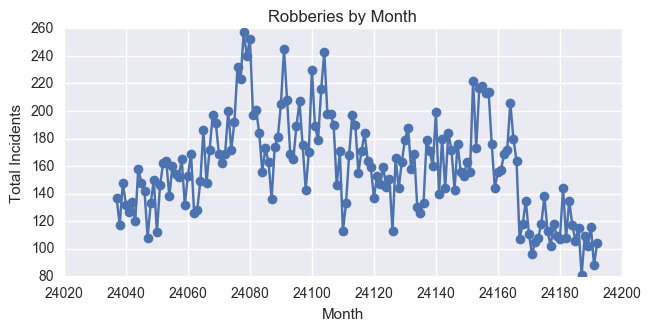

In [7]:
def monthyear2num(month,year):
    return year*12 + month

def num2monthyear(num):
    month = num % 12
    year = (num-month) / 12
    return "%.2d/%.2d" % (month,year)

groupbyyearmonth = df[['year','month']].groupby(by=['year','month']).size().to_frame(name="count")
groupbyyearmonth.reset_index(inplace=True)
groupbyyearmonth['monthyear'] = groupbyyearmonth.apply(lambda row: row['year']*12 + row['month'],axis=1)

plt.figure(figsize=(7.2,3.2))
plt.plot(groupbyyearmonth['monthyear'],groupbyyearmonth['count'],'o-')
plt.xlabel('Month')
plt.ylabel('Total Incidents')
plt.title(uppercase+' by Month')
pass

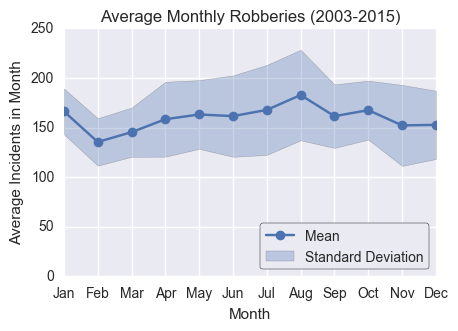

In [11]:
groupbymonth = groupbyyearmonth[['month','count']].groupby(by='month')
groupbymonth = groupbymonth['count'].agg({'sum' : sum, 'mean' : np.mean, 'std' : np.std})

plot_mean = plt.plot(groupbymonth.index,groupbymonth['mean'],'o-')
plot_std = plt.fill_between(groupbymonth.index, 
                 groupbymonth['mean']-groupbymonth['std'], 
                 groupbymonth['mean']+groupbymonth['std'],
                 alpha=.3)
plt.xlabel('Month')
plt.ylabel('Average Incidents in Month')
plt.title('Average Monthly %s (2003-2015)' % uppercase)
leg = plt.legend(['Mean','Standard Deviation'],loc='lower right')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([1, 12, 0, 700])
elif dataset == 'robberies':
    plt.axis([1, 12, 0, 250])

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.savefig('plots/%s-monthlyaverage.png' % lowercase)
pass


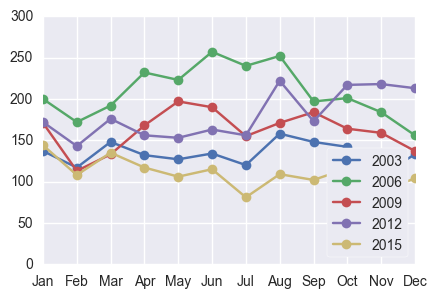

In [15]:
yearlist = [2003, 2006, 2009, 2012, 2015]
for year in yearlist:
    plt.plot(groupbyyearmonth[groupbyyearmonth.year==year]['month'],groupbyyearmonth[groupbyyearmonth.year==year]['count'],'o-')
plt.legend(yearlist,loc='lower right')
if dataset == 'thefts':
    plt.axis([1, 12, 0, 700])
elif dataset == 'robberies':
    plt.axis([1, 12, 0, 300])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
pass

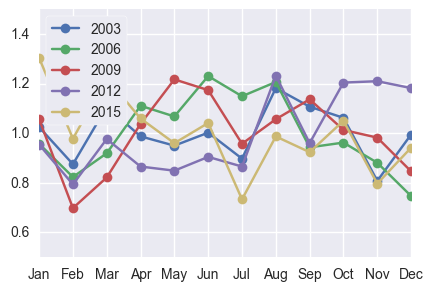

In [13]:
yearlist = [2003, 2006, 2009, 2012, 2015]
for year in yearlist:
    y = groupbyyearmonth[groupbyyearmonth.year==year]['count']/groupbyyearmonth[groupbyyearmonth.year==year]['count'].mean()
    plt.plot(groupbyyearmonth[groupbyyearmonth.year==year]['month'],y,'o-')
plt.legend(yearlist,loc='upper left')
plt.axis([1, 12, 0.5, 1.5])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
pass

## Daily counts over time

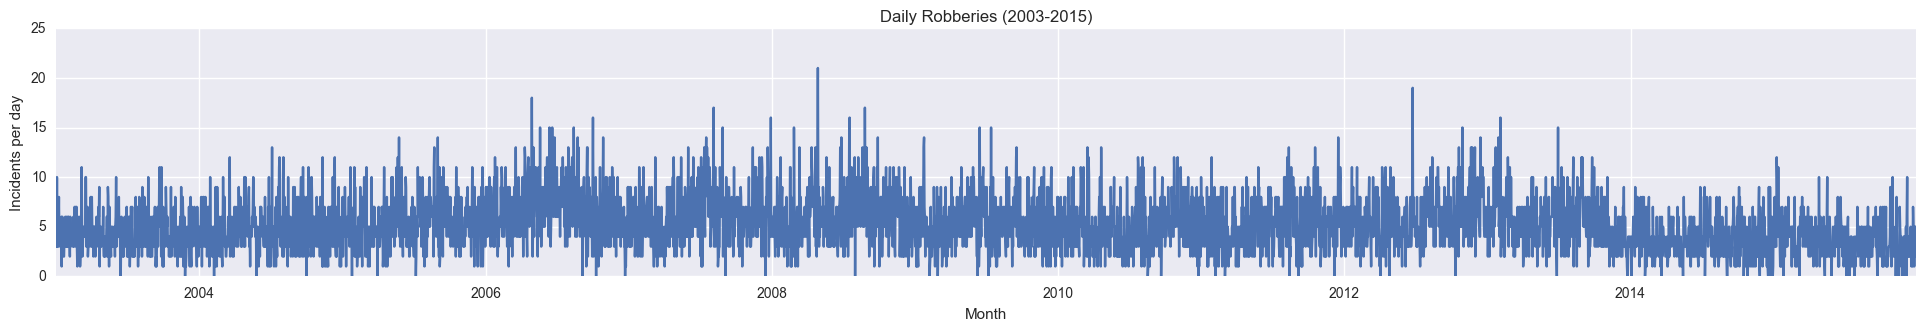

In [16]:
plt.figure(figsize=(4.8*5,3.2))
plt.plot(groupbydate['date'],groupbydate['count'],'-')
plt.xlabel('Month')
plt.ylabel('Incidents per day')
plt.title('Daily %s (2003-2015)' % uppercase)
pass

# Aggregated by time of day

In [17]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts

def scott_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 1.06*sigma*S.count()**(-0.2)

def silverman_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 0.9*sigma*S.count()**(-0.2)

class WrappedKDE:
    
    def __init__(self,S):
        # S is a pandas series
        self.bandwidth = silverman_bw(S)
        self.model = KernelDensity(bandwidth=self.bandwidth)
        return None
        
    def fit(self,data):
        self.model.fit(data.reshape(-1,1))
        return self
    
    def pdf(self,grid):
        grid = grid.reshape(-1,1)
        griddelta = grid[1]-grid[0]
        gridmax = grid[-1]+griddelta
        out = np.exp(self.model.score_samples(grid))
        out += np.exp(self.model.score_samples(grid-gridmax))
        out += np.exp(self.model.score_samples(grid+gridmax))
        return out

timekde = WrappedKDE(df.time.apply(time2num))
timekde.fit(df.time.apply(time2num))
print timekde.bandwidth
#timegrid = np.arange(1,1440,1)
#plt.scatter(timegrid, timekde.pdf(timegrid))
#plt.axis([0, 1440, 0, 0.002])

56.3635406197


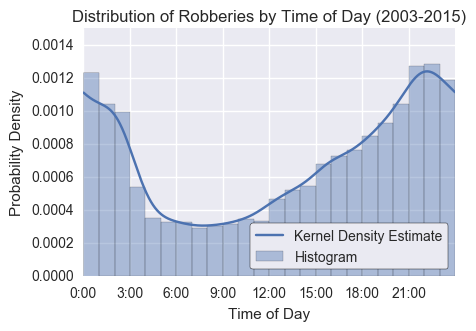

In [18]:
hours = ['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00']
#plt.hist(df.time.apply(time2num),bins=24,normed=True,alpha=0.5)
sns.distplot(df.time.apply(time2num),kde = False,norm_hist=True,bins=24)

timegrid = np.arange(1,1440,1)
plt.plot(timegrid,timekde.pdf(timegrid),'-',color=sns.color_palette()[0])

plt.axis([0,1440,0,0.0015])
plt.xticks(range(0,1440,180), hours)

plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Distribution of %s by Time of Day (2003-2015)' % uppercase)
if dataset == 'thefts':
    legloc = 'upper right'
elif dataset == 'robberies':
    legloc = 'lower right'
leg = plt.legend(['Kernel Density Estimate','Histogram'],loc=legloc)
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.savefig('plots/%s-timeofdaydistribution.png' % lowercase)
pass

# Aggregation by day of week

In [ ]:
weekdayno ={ 
    u'Monday' : 1,
    u'Tuesday' : 2,
    u'Wednesday' : 3,
    u'Thursday' : 4,
    u'Friday' : 5,
    u'Saturday' : 6,
    u'Sunday' : 7
    }
groupbydate['dayofweekno'] = groupbydate['dayofweek'].apply(lambda x: weekdayno[x])

groupbyweekday = groupbydate.groupby(by=['dayofweekno','dayofweek'])
groupbyweekday = groupbyweekday['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyweekday['stderr'] = groupbyweekday.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
groupbyweekday.reset_index(inplace=True)

print groupbyweekday

weekdaylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

p = plt.bar(left=groupbyweekday['dayofweekno'].as_matrix(),
           height=groupbyweekday['mean'].as_matrix(),
           width=0.8,
           tick_label=weekdaylabels,
           align='center',
           yerr = groupbyweekday['std'],
           alpha=0.66)
if dataset == 'thefts':
    plt.axis([0.5,7.5,0,25])
elif dataset == 'robberies':
    plt.axis([0.5,7.5,0,11])
plt.title('Average Daily %s against Day of Week' % uppercase)
plt.ylabel('Incidents per Day')
leg = plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.savefig('plots/%s-dayofweekaverage.png' % lowercase)
pass

In [ ]:
p = plt.plot(groupbydate['dayofweekno'],groupbydate['count'],'.')
if dataset == 'thefts':
    plt.axis([0.5,7.5,0,70])
elif dataset == 'robberies':
    pass

plt.title('Daily Total %s by Day of Week (2003-2015)' % uppercase)
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Days'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.xticks(range(1,8,1), weekdaylabels)

pass

# Aggregation by spatial location

In [ ]:
# Fit spatial KDE

def silverman_bwxy(df):
    count = df['x'].count()
    stdx = df['x'].std()
    stdy = df['y'].std()
    iqrx = np.subtract(*np.percentile(df['x'], [75, 25]))
    iqry = np.subtract(*np.percentile(df['y'], [75, 25]))
    sigma = min(stdx,stdy,iqrx,iqry)
    return 0.9*sigma*count**(-0.2)

spacekde = KernelDensity(bandwidth = silverman_bwxy(df[['x','y']]),metric='haversine')
spacekde.fit(df[['x','y']])


In [ ]:
# Sample on a grid

xmin = -122.5237517
xmax = -122.3522017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.arange(xmin,xmax,0.0004),np.arange(ymin,ymax,0.0004))
#xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=400),np.linspace(ymin,ymax,num=100))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()



Z = np.exp(spacekde.score_samples(X_grid))
Zv = Z.reshape(xv.shape)

levels = np.linspace(Zv.min(), Zv.max(), 25)
plt.contourf(xv, yv, Zv, levels=levels, cmap=plt.cm.Reds)
plt.title('Kernel Density Estimate of %s' % uppercase)
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.savefig('plots/%s-spatialkdeheatmap.png' % lowercase)

In [ ]:
# Save sampled data to file

Z_filt = Z/Z.max()

tol = 1e-4
Z_filt[abs(Z_filt) < tol] = 0.0

out = [[point[0], point[1], point[2]] for point in zip(X_grid[:,1],X_grid[:,0],Z_filt)]

with open("%s_kde.csv" % lowercase, "wb") as f:
    writer = csv.writer(f)
    writer.writerows(out)

# Weather

In [ ]:
weather[weather.DATE < date(2016, 1, 1)].hist()
print weather[weather.DATE < date(2016, 1, 1)].shape
pass

## Aggregation by precipitation

In [ ]:
binsize = 2
binmin, binmax = 0, 90
plt.hist(groupbydate['PRCP'],normed=False,bins=range(0,binmax+1,binsize),log=True)

plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Precipitation (2003-2015)')

plt.savefig('plots/precip_hist.png')

pass

In [ ]:
binsize = 2
binmin, binmax = 0, 90

groupbyprcp = groupbydate.groupby(pd.cut(groupbydate.PRCP,bins=range(0,binmax+1,binsize),right=False))
groupbyprcp = groupbyprcp['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyprcp['stderr'] = groupbyprcp.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbyprcp

p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbyprcp['mean'].as_matrix(),
           width=binsize,
           yerr = groupbyprcp['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbyprcp['mean'].as_matrix(), 
             yerr=groupbyprcp['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s by Precipitation' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.','Std. Err.'],loc='upper right',frameon=True,fancybox=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,22])
elif dataset == 'robberies':
    pass


plt.savefig('plots/%s-precipaverage.png' % lowercase)


In [ ]:
p = plt.plot(groupbydate['PRCP'],groupbydate['count'],'.')

# Fit linear regression
prcp_linreg = LinearRegression()
prcp_linreg.fit(groupbydate['PRCP'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
r2 = prcp_linreg.score(groupbydate['PRCP'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
print r2

# Plot linear regression
x = np.arange(0,91,1).reshape(-1,1)
plt.plot(x,prcp_linreg.predict(x))

plt.title('Total Daily %s by Precipitation (2003-2015)' % uppercase)
plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Day Observations','Linear Fit ($r^2 = %.3f$)' % r2],loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')

plt.savefig('plots/%s-preciplinfit.png' % lowercase)

pass

## Aggregation by TMAX

In [ ]:
binsize = 2
binmin, binmax = 44, 98
plt.hist(groupbydate['TMAX'],normed=False,bins=range(binmin,binmax+1,binsize))

plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Daily High Temp. (2003-2015)')

plt.savefig('plots/tmax_hist.png')

pass

In [ ]:
binsize = 2
binmin, binmax = 44, 98

#binsize = 5
#binmin, binmax = 40, 100

groupbytmax = groupbydate.groupby(pd.cut(groupbydate['TMAX'],bins=range(binmin,binmax+1,binsize),right=False))
groupbytmax = groupbytmax['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmax['stderr'] = groupbytmax.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmax


p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbytmax['mean'].as_matrix(),
           width=binsize,
           yerr = groupbytmax['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbytmax['mean'].as_matrix(), 
             yerr=groupbytmax['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s against Daily High Temp.' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.', 'Std. Err.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,29])
elif dataset == 'robberies':
    plt.axis([binmin,binmax,0,13])
plt.savefig('plots/%s-tmaxaverage.png' % lowercase)
pass

### Linear regression

In [ ]:
p = plt.plot(groupbydate['TMAX'],groupbydate['count'],'.')

# Fit linear regression
tmax_linreg = LinearRegression()
tmax_linreg.fit(groupbydate['TMAX'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
r2 = prcp_linreg.score(groupbydate['TMAX'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
print r2

# Plot linear regression
x = np.arange(44,99,1).reshape(-1,1)
plt.plot(x,prcp_linreg.predict(x))

plt.title('Total Daily %s by Daily High Temp. (2003-2015)' % uppercase)
plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Day Observations','Linear Fit ($r^2 = %.3f$)' % r2],loc='upper right',frameon=True,fancybox=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([40,100,0,90])
elif dataset == 'robberies':
    plt.axis([40,100,0,30])

pass

This is no good. $r^2 = -1.5$ which means fit is worse than horizontal line.

### Parabolic regression

In [ ]:
p = plt.plot(groupbydate['TMAX'],groupbydate['count'],'.')

# Fit polynomial regression
tmax_polypipe = Pipeline([
    ('polytrans',PolynomialFeatures(2)), 
    ('ridge',Ridge())
    ])
params = {'ridge__alpha' : np.linspace(0,2,20) }


cv = GridSearchCV(tmax_polypipe, param_grid=params)

x_dat = groupbydate['TMAX'].as_matrix().reshape(-1,1)
y_dat = groupbydate['count'].as_matrix().reshape(-1,1)
cv.fit(x_dat, y_dat)

print cv.best_params_
print cv.best_score_

x_plot = np.arange(44,99,1).reshape(-1,1)
y_plot = cv.predict(x_plot)

plt.plot(x_plot,y_plot)
plt.title('Total Daily %s by Daily High Temp. (2003-2015)' % uppercase)
plt.xlabel('Daily High Temperature (degr F)')
leg = plt.legend(['Individual Day Observations','Parabolic fit Fit ($r^2 = %.3f$)' % cv.best_score_],loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([40,100,0,90])
elif dataset == 'robberies':
    plt.axis([40,100,0,30])


This is no good. $r^2 = -1.5$ which means fit is worse than horizontal line.

## Aggregation by TMIN

In [ ]:
binsize = 2
binmin, binmax = 35, 69
plt.hist(groupbydate['TMIN'],normed=False,bins=range(binmin,binmax+1,binsize),log=False)

plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Daily Low Temp. (2003-2015)')


plt.savefig('plots/tmin_hist.png')

pass

In [ ]:
binsize = 2
binmin, binmax = 35, 69

#binsize = 5
#binmin, binmax = 35, 70

groupbytmin = groupbydate.groupby(pd.cut(groupbydate['TMIN'],bins=range(binmin,binmax+1,binsize),right=False))
groupbytmin = groupbytmin['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmin['stderr'] = groupbytmin.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmin

p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbytmin['mean'].as_matrix(),
           width=binsize,
           yerr = groupbytmin['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbytmin['mean'].as_matrix(), 
             yerr=groupbytmin['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s against Daily Low Temp.' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.', 'Std. Err.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,28])
elif dataset == 'robberies':
    plt.axis([binmin,binmax,0,13])
plt.savefig('plots/%s-tminaverage.png' % lowercase)
pass